In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [35]:
train = pd.read_csv('C:/dacon/open/train.csv')
test = pd.read_csv('C:/dacon/open/test.csv')

<AxesSubplot:xlabel='first_party_winner', ylabel='count'>

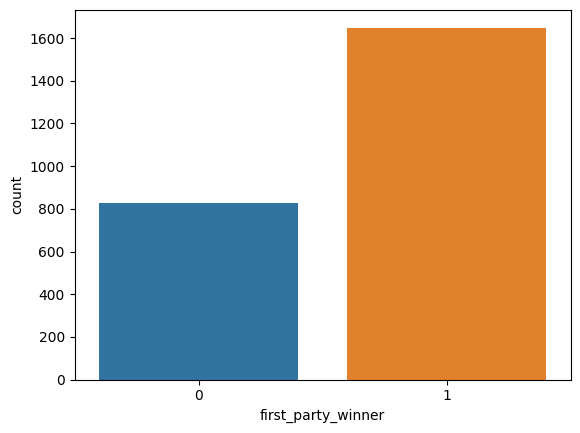

In [9]:
# train data 종속변수 확인 -> 불균형 데이터
import seaborn as sns
sns.countplot(data=train, x='first_party_winner')

- preprocessing -텍스트 데이터 전처리

In [13]:
pd.options.display.max_colwidth = 2000 # 2000자까지 다 표시
train.head(1)

,ID,first_party,second_party,facts,first_party_winner
0,TRAIN_0000,Phil A. St. Amant,Herman A. Thompson,"On June 27, 1962, Phil St. Amant, a candidate for public office, made a television speech in Baton Rouge, Louisiana. During this speech, St. Amant accused his political opponent of being a Communist and of being involved in criminal activities with the head of the local Teamsters Union. Finally, St. Amant implicated Herman Thompson, an East Baton Rouge deputy sheriff, in a scheme to move money between the Teamsters Union and St. Amant’s political opponent. \nThompson successfully sued St. Amant for defamation. Louisiana’s First Circuit Court of Appeals reversed, holding that Thompson did not show St. Amant acted with “malice.” Thompson then appealed to the Supreme Court of Louisiana. That court held that, although public figures forfeit some of their First Amendment protection from defamation, St. Amant accused Thompson of a crime with utter disregard of whether the remarks were true. Finally, that court held that the First Amendment protects uninhibited, robust debate, rather than an open season to shoot down the good name of anyone who happens to be a public servant. \n",1


In [36]:
# ID열 제거 
train.drop(['ID'], axis=1, inplace=True)
test.drop(['ID'], axis=1, inplace=True)

In [37]:
# 대문자를 소문자로 변경
train = train.apply(lambda x: x.str.lower() if x.dtype == "object" else x)
test = test.apply(lambda x: x.str.lower() if x.dtype == "object" else x)

In [38]:
train.head(1)

,first_party,second_party,facts,first_party_winner
0,phil a. st. amant,herman a. thompson,"on june 27, 1962, phil st. amant, a candidate for public office, made a television speech in baton rouge, louisiana. during this speech, st. amant accused his political opponent of being a communist and of being involved in criminal activities with the head of the local teamsters union. finally, st. amant implicated herman thompson, an east baton rouge deputy sheriff, in a scheme to move money between the teamsters union and st. amant’s political opponent. \nthompson successfully sued st. amant for defamation. louisiana’s first circuit court of appeals reversed, holding that thompson did not show st. amant acted with “malice.” thompson then appealed to the supreme court of louisiana. that court held that, although public figures forfeit some of their first amendment protection from defamation, st. amant accused thompson of a crime with utter disregard of whether the remarks were true. finally, that court held that the first amendment protects uninhibited, robust debate, rather than an open season to shoot down the good name of anyone who happens to be a public servant. \n",1


In [16]:
# 정규 표현식 패턴을 사용하여 특수 문자 제거
import re

def remove_special_characters(text):
    pattern = r'[^a-zA-Z0-9\s]'
    processed_text = re.sub(pattern, '', text)
    return processed_text

# 'facts' 열의 특수 문자 제거
train = train.apply(lambda x: x.apply(remove_special_characters) if x.dtype == "object" else x)
test = test.apply(lambda x: x.apply(remove_special_characters) if x.dtype == "object" else x)

In [43]:
import nltk
from nltk.stem import WordNetLemmatizer

# nltk.download('wordnet')

# WordNetLemmatizer 객체 생성
lemmatizer = WordNetLemmatizer()

# 'facts' 열의 데이터를 원형으로 변환하는 함수
def lemmatize_text(text):
    words = nltk.word_tokenize(text)  # 텍스트를 단어로 분리
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]  # 단어를 원형으로 변환
    lemmatized_text = ' '.join(lemmatized_words)  # 원형으로 변환된 단어들을 다시 문장으로 연결
    return lemmatized_text

# 'facts' 열에 WordNetLemmatizer 적용
train['facts'] = train['facts'].apply(lemmatize_text)
test['facts'] = test['facts'].apply(lemmatize_text)

In [60]:
# 훈련 데이터와 검증 데이터로 분리 
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(train.drop(columns=['first_party_winner']), train['first_party_winner']
                                                      , test_size=0.3, random_state=42, stratify = train['first_party_winner'])

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((1734, 3), (744, 3), (1734,), (744,))

In [61]:
# Count 벡터화를 수행
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
def get_vector(vectorizer, df, train_mode):
    if train_mode:
        X_facts = vectorizer.fit_transform(df['facts'])
    else:
        X_facts = vectorizer.transform(df['facts'])
        
    X_party1 = vectorizer.transform(df['first_party'])
    X_party2 = vectorizer.transform(df['second_party'])
    
    X = np.concatenate([X_party1.todense(), X_party2.todense(), X_facts.todense()], axis=1)
    return X

In [62]:
# 훈련 데이터
X_train = get_vector(vectorizer, X_train, True)
y_train
print("훈련 데이터 타입: ", type(X_train))

# 검증 데이터
X_valid = get_vector(vectorizer, X_valid, False)
y_valid
print("검증 데이터 타입: ", type(X_valid))

# 테스트 데이터 
X_test = get_vector(vectorizer, test, False)
print("테스트 데이터 타입: ", type(X_test))

훈련 데이터 타입:  <class 'numpy.matrix'>
검증 데이터 타입:  <class 'numpy.matrix'>
테스트 데이터 타입:  <class 'numpy.matrix'>


In [63]:
# 학습 및 예측을 위한 데이터 타입 변경
X_train = np.asarray(X_train)
X_valid = np.asarray(X_valid)
X_test = np.asarray(X_test)

In [64]:
# SMOTE를 통한 oversampling (훈련 데이터에만 적용)
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)

X_train_over,y_train_over = smote.fit_resample(X_train, y_train)

## Train

- 로지스틱 회귀모델

In [103]:
lr_model = LogisticRegression().fit(X_train, y_train)

C:\Users\User\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [104]:
lr_model.score(X_train, y_train)

1.0

In [105]:
y_pred = lr_model.predict(X_valid)

# 정확도 평가 
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_valid, y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.5981182795698925


In [81]:
submit = pd.read_csv('C:/dacon/open/sample_submission.csv')

In [84]:
y_pred = lr_model.predict(X_test)
submit['first_party_winner'] = y_pred
submit.to_csv('./file1.csv', index=False)
print('Done')

array([1, 0, 1, 1, 1], dtype=int64)

In [101]:
import statsmodels.api as sm 
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

plt.rc('font', family = 'Malgun Gothic')

In [106]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_curve, r2_score, accuracy_score 
from sklearn.metrics import recall_score, precision_score, confusion_matrix, classification_report, roc_auc_score, auc

# ROC curve

## Roc curve 패키지로 fpr, tpr 뽑기 
probs = lr_model.predict_proba(X_valid)[:,1]
model_fpr, model_tpr, threshold1 = roc_curve(y_valid, probs)

In [108]:
random_fpr, random_tpr, threshold2 = roc_curve(y_valid, [0 for i in range(len(X_valid))])

random_fpr, random_tpr, threshold2

(array([0., 1.]), array([0., 1.]), array([1, 0]))

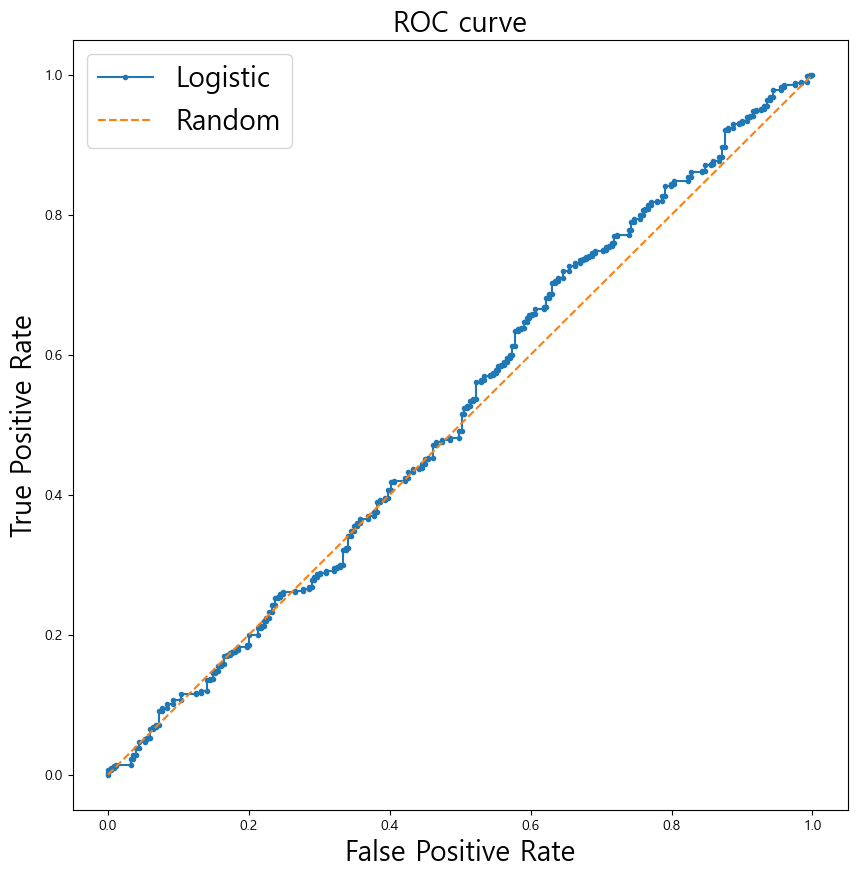

In [109]:
plt.figure(figsize = (10,10))
plt.plot(model_fpr, model_tpr, marker = '.', label = "Logistic")
plt.plot(random_fpr, random_tpr, linestyle = '--', label = "Random")

plt.xlabel("False Positive Rate", size = 20)
plt.ylabel("True Positive Rate", size = 20)

plt.legend(fontsize = 20)

plt.title("ROC curve", size = 20)
plt.show()

In [110]:
### AUC 값 확인하기 (ROC curve 아래 부분 면적)
roc_auc = auc(model_fpr, model_tpr)
print("\n\n ROC AUC score : ", roc_auc)



 ROC AUC score :  0.5166200154151962


In [116]:
# grid_search 이용
# grid_search는 최적의 parameter를 찾고 이를 이용하여 train, validation를 합친 data를 fit 한다.

from sklearn.model_selection import GridSearchCV

param_grid = {
    'C' : [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter' : [100,1000]
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=10)

grid_search.fit(X_train, y_train)
print('test accuracy : ', grid_search.score(X_valid, y_valid))
print('최적의 parameters : ', grid_search.best_params_)

C:\Users\User\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\User\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

test accuracy :  0.6639784946236559
최적의 parameters :  {'C': 0.001, 'max_iter': 100}


In [117]:
print('test accuracy : ', grid_search.score(X_valid, y_valid))
print('최적의 parameters : ', grid_search.best_params_)

test accuracy :  0.6639784946236559
최적의 parameters :  {'C': 0.001, 'max_iter': 100}


In [118]:
lf_clf = LogisticRegression(C = 0.001, max_iter = 100).fit(X_train, y_train)

In [119]:
pred = lf_clf.predict(X_valid)
print("Accuracy: ", accuracy_score(y_valid, pred))

Accuracy:  0.6639784946236559


- 랜덤포레스트

In [71]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [72]:
rf_model = RandomForestClassifier().fit(X_train, y_train)

In [74]:
rf_model.fit(X_train, y_train)

Pipeline(steps=[('rf', RandomForestClassifier())])

In [76]:
rf_model.score(X_train, y_train)

1.0

In [77]:
# 검증 데이터 정확도
rf_model.score(X_valid, y_valid)

0.657258064516129

In [86]:
y_pred1 = rf_model.predict(X_test)
y_pred1[:5]

array([1, 1, 1, 1, 1], dtype=int64)

In [88]:
# 제출
submit['first_party_winner'] = y_pred1
submit.to_csv('./rf_model.csv', index=False)
print('Done')

Done


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import optuna

In [90]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Objective 함수 정의
def objective(trial):
    # 하이퍼파라미터 탐색 공간 정의
    n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
    max_depth = trial.suggest_int('max_depth', 15, 30, step=1)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10, step=1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10, step=1)

    # 랜덤 포레스트 모델 생성
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    
    # cross validation 수행
    scores = cross_val_score(model, X_train, y_train, cv=10)  # cv는 원하는 폴드 수로 설정
    
    # cross validation의 평균 정확도 계산
    avg_accuracy = scores.mean()
    
    return avg_accuracy

In [91]:
study = optuna.create_study(direction='maximize') # accuracy를 최대화하므로 'maximize'로 설정
study.optimize(objective, n_trials=10)

best_params = study.best_params
best_score = study.best_value
print('Best Parameters:', best_params)
print('Best accuracy score:', best_score)

[I 2023-06-28 15:30:09,536] A new study created in memory with name: no-name-486241b6-c682-490e-93d2-9492a1b41f52
[I 2023-06-28 15:37:29,243] Trial 0 finished with value: 0.6655105973025048 and parameters: {'n_estimators': 1000, 'max_depth': 27, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.6655105973025048.
[I 2023-06-28 15:44:51,126] Trial 1 finished with value: 0.6655105973025048 and parameters: {'n_estimators': 700, 'max_depth': 25, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.6655105973025048.
[I 2023-06-28 15:50:36,464] Trial 2 finished with value: 0.6655105973025048 and parameters: {'n_estimators': 600, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.6655105973025048.
[I 2023-06-28 15:57:37,380] Trial 3 finished with value: 0.6655105973025048 and parameters: {'n_estimators': 800, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 0 with val

Best Parameters: {'n_estimators': 1000, 'max_depth': 27, 'min_samples_split': 10, 'min_samples_leaf': 6}
Best accuracy score: 0.6655105973025048


In [92]:
best_model = RandomForestClassifier(
    n_estimators = best_params['n_estimators'],
    max_depth = best_params['max_depth'],
    min_samples_split = best_params['min_samples_split'],
    min_samples_leaf = best_params['min_samples_leaf'],
    random_state=42
)
best_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=27, min_samples_leaf=6, min_samples_split=10,
                       n_estimators=1000, random_state=42)

In [93]:
y_valid_pred = best_model.predict(X_valid)

In [94]:
accuracy_score(y_valid, y_valid_pred)

0.6653225806451613

- XGB

In [96]:
from xgboost import XGBClassifier
XGB_model = XGBClassifier()
XGB_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [97]:
y_pred = XGB_model.predict(X_valid)
predictions = [round(value) for value in y_pred]

In [100]:
# evaluate predictions
from sklearn.metrics import f1_score
accuracy_score(y_valid, predictions)

0.6236559139784946

- performing LDA and hyper-parameter tuning

In [120]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=200, random_state=0)
lda_data = lda.fit_transform(X_train)

In [121]:
lda_data_train = pd.DataFrame(data=lda_data)

In [122]:
lda_data_valid = pd.DataFrame(data=lda.transform(X_valid))

In [123]:
lda_data_test = pd.DataFrame(data=lda.transform(X_test))

In [126]:
# Create the parameter grid based on the results of random search 
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [8,10,12],
    'max_features': [80,90,100],
    'min_samples_leaf': [3, 4, 6],
    'n_estimators': [100, 200, 300]
}# Create a based model
rf = RandomForestClassifier()# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [127]:
grid_search.fit(lda_data_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 81 candidates, totalling 243 fits


{'max_depth': 8,
 'max_features': 80,
 'min_samples_leaf': 6,
 'n_estimators': 200}

In [128]:
rand=RandomForestClassifier(max_depth= 8, max_features = 80, min_samples_leaf = 6, n_estimators = 200)

In [129]:
rand.fit(lda_data_train,y_train)

RandomForestClassifier(max_depth=8, max_features=80, min_samples_leaf=6,
                       n_estimators=200)

In [130]:
rand.score(lda_data_train,y_train)

0.7041522491349481

In [131]:
rand.score(lda_data_valid,y_valid)

0.6532258064516129

In [132]:
from sklearn.metrics import f1_score

In [133]:
y_pred1 = rand.predict(lda_data_valid)
f1_score(y_valid, y_pred1)

0.7820945945945946

- LSTM

In [134]:
import numpy as np
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

In [135]:
n_unique_words = 10000 # cut texts after this number of words
maxlen = 2000
batch_size = 32

In [136]:
model = Sequential()
model.add(Embedding(n_unique_words, 128, input_length=maxlen))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [138]:
history=model.fit(lda_data_train, y_train,
           batch_size=batch_size,
           epochs=200,
           validation_data=[lda_data_valid, y_valid])

Epoch 1/200


ValueError: in user code:

    File "c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 2000), found shape=(None, 200)
